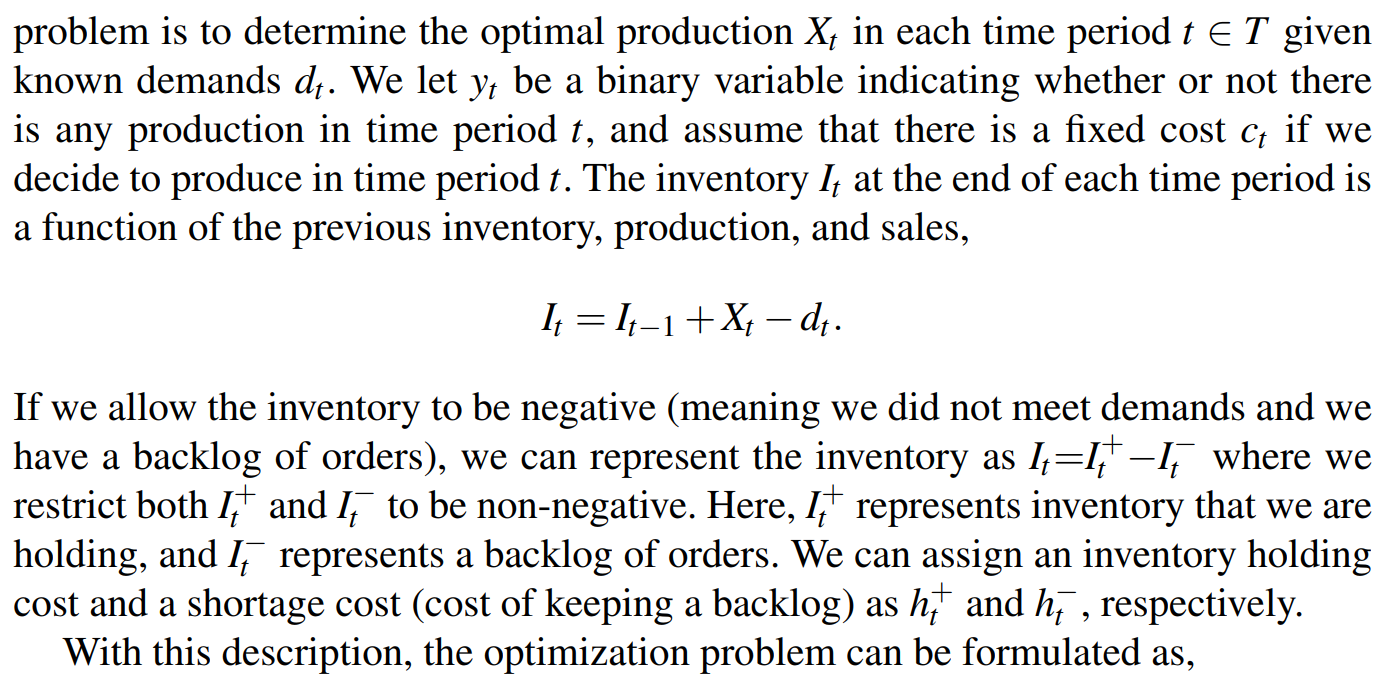

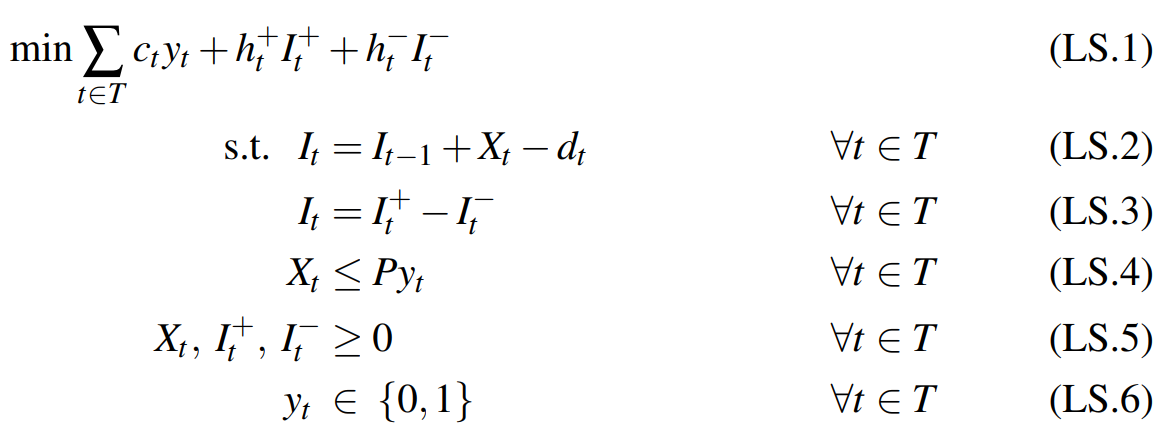

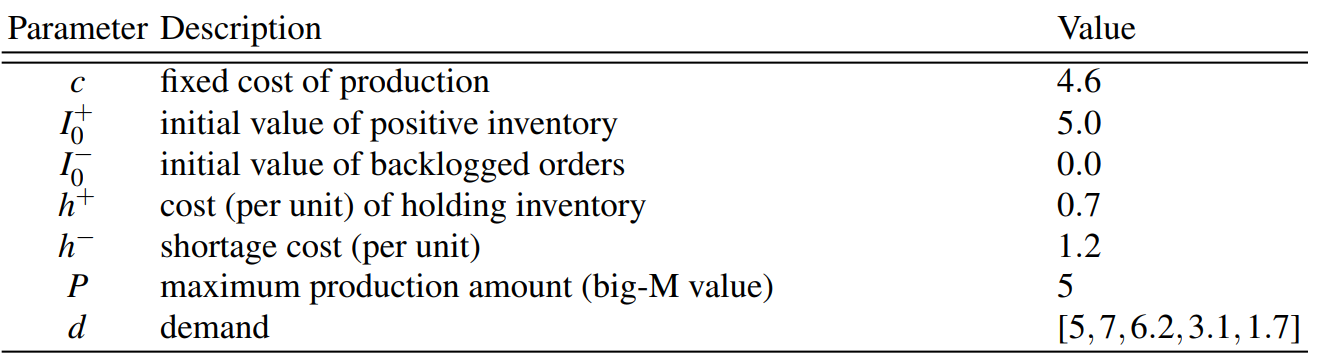

In [1]:
import pyomo.environ as pyo

In [5]:
model = pyo.ConcreteModel()

model.T = pyo.RangeSet(5) # time periods

i0 = 5.0 # initial inventory
c = 4.6 # setup cost
h_pos = 0.7 # inventory holding cost
h_neg = 1.2 # shortage cost
P = 5.0 # maximum production amount

# demand during period t
d = {1: 5.0, 2:7.0, 3:6.2, 4:3.1, 5:1.7}

# define the variables
model.y = pyo.Var(model.T, domain=pyo.Binary)
model.x = pyo.Var(model.T, domain=pyo.NonNegativeReals)
model.i = pyo.Var(model.T)
model.i_pos = pyo.Var(model.T, domain=pyo.NonNegativeReals)
model.i_neg = pyo.Var(model.T, domain=pyo.NonNegativeReals)

# define the inventory relationships
def inventory_rule(m, t):
    if t == m.T.first():
        return m.i[t] == i0 + m.x[t] - d[t]
    return m.i[t] == m.i[t-1] + m.x[t] - d[t]
model.inventory = pyo.Constraint(model.T, rule=inventory_rule)

def pos_neg_rule(m, t):
    return m.i[t] == m.i_pos[t] - m.i_neg[t]
model.pos_neg = pyo.Constraint(model.T, rule=pos_neg_rule)

# create the big-M constraint for the production indicator variable
def prod_indicator_rule(m,t):
    return m.x[t] <= P*m.y[t]
model.prod_indicator = pyo.Constraint(model.T, rule=prod_indicator_rule)

# define the cost function
def obj_rule(m):
    return sum(c*m.y[t] + h_pos*m.i_pos[t] + h_neg*m.i_neg[t] for t in m.T)
model.obj = pyo.Objective(rule=obj_rule)

# solve the problem
solver = pyo.SolverFactory("glpk")
solver.solve(model)

# print the results
for t in model.T:
    print("Period: {0}, Prod. Amount: {1}".format(t, pyo.value(model.x[t])))

Period: 1, Prod. Amount: 3.0
Period: 2, Prod. Amount: 5.0
Period: 3, Prod. Amount: 5.0
Period: 4, Prod. Amount: 5.0
Period: 5, Prod. Amount: 0.0


### in one time step the variables would be:

In [ ]:
model.y = pyo.Var(domain=pyo.Binary)
model.x = pyo.Var(domain=pyo.NonNegativeReals)
model.i = pyo.Var()
model.i_pos = pyo.Var(domain=pyo.NonNegativeReals)
model.i_neg = pyo.Var(domain=pyo.NonNegativeReals)

If we were considering a multi-period and multi-scenario problem (e.g., a stochastic
programming formulation for lot-sizing under uncertainty), the variable declarations
would have looked like

In [ ]:
model.y = pyo.Var(model.T, model.S, domain=pyo.Binary)
model.x = pyo.Var(model.T, model.S, domain=pyo.NonNegativeReals)
model.i = pyo.Var(model.T, model.S,)
model.i_pos = pyo.Var(model.T, model.S, domain=pyo.NonNegativeReals)
model.i_neg = pyo.Var(model.T, model.S, domain=pyo.NonNegativeReals)

## using blocks

In each of these examples, when we add new complexity, or an additional layer
onto the model, we add a new index to the variables and constraints. This approach
is very common in the field of operations research. Unfortunately, it requires completely redefining the model with each new layer, and it does not readily support
construction of hierarchical models with reusable code. Blocks provide another approach to easily support model reuse in an object-oriented fashion

In [6]:
model = pyo.ConcreteModel()

model.T = pyo.RangeSet(5) # time periods

i0 = 5.0 # initial inventory
c = 4.6 # setup cost
h_pos = 0.7 # inventory holding cost
h_neg = 1.2 # shortage cost
P = 5.0 # maximum production amount

# demand during period t
d = {1: 5.0, 2:7.0, 3:6.2, 4:3.1, 5:1.7}

# create a block for a single time period
def lotsizing_block_rule(b, t):
    # define the variables
    b.y = pyo.Var(domain=pyo.Binary)
    b.x = pyo.Var(domain=pyo.NonNegativeReals)
    b.i = pyo.Var()
    b.i0 = pyo.Var()
    b.i_pos = pyo.Var(domain=pyo.NonNegativeReals)
    b.i_neg = pyo.Var(domain=pyo.NonNegativeReals)
    # define the constraints
    b.inventory = pyo.Constraint(expr=b.i == b.i0 + b.x - d[t])
    b.pos_neg = pyo.Constraint(expr=b.i == b.i_pos - b.i_neg)
    b.prod_indicator = pyo.Constraint(expr=b.x <= P * b.y)
model.lsb = pyo.Block(model.T, rule=lotsizing_block_rule)

# link the inventory variables between blocks
def i_linking_rule(m, t):
    if t == m.T.first():
        return m.lsb[t].i0 == i0
    return m.lsb[t].i0 == m.lsb[t-1].i
model.i_linking = pyo.Constraint(model.T, rule=i_linking_rule)

# construct the objective function over all the blocks
def obj_rule(m):
    return sum(c*m.lsb[t].y + h_pos*m.lsb[t].i_pos + h_neg*m.lsb[t].i_neg for t in m.T)
model.obj = pyo.Objective(rule=obj_rule)

### solve the problem
solver = pyo.SolverFactory("glpk")
solver.solve(model)

# print the results
for t in model.T:
    print("Period: {0}, Prod. Amount: {1}".format(t, pyo.value(model.lsb[t].x)))

Period: 1, Prod. Amount: 3.0
Period: 2, Prod. Amount: 5.0
Period: 3, Prod. Amount: 5.0
Period: 4, Prod. Amount: 5.0
Period: 5, Prod. Amount: 0.0


This formulation is small, so it can be difficult to see the benefit of blocks. However, as models grow in size and complexity, this object-oriented modeling concept
allows us to define small pieces of the model in self-contained chunks of code, and
then build the large model by pulling these pieces together. This example was selected in part because it is a heavily studied, classic multi-stage inventory model.
One can easily imagine extensions to the model to include additional constraints
and costs. In fact, many such models have appeared in the academic literature and
in practical application. In large models, it is common to write methods or classes
to define individual blocks and reuse code within several different, high-level optimization formulations.